## Image classification with deep learning methods.

-- Description --

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [42]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

## Download the imaging dataset

You can browse the imaging datasets on their webpage https://medmnist.com/, and download them as such:


In [43]:
# Install and import the MedMNIST package and datasets.

!pip install medmnist
import medmnist
from medmnist import info

In [44]:
from medmnist import *

# Preprocesado de datos mediante la definición de la transformación de datos
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

blood_train_dataset = BloodMNIST(split="train", transform=data_transform, download=True, size= 28)
blood_valid_dataset = BloodMNIST(split="val", transform=data_transform, download=True, size= 28)
blood_test_dataset = BloodMNIST(split="test", transform=data_transform, download=True, size= 28)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


## Visualize the imaging dataset

You can find relevant information about the datasets in the info.INFO dictionary.

For visualizing the images, you can use the montage method, though we recomend
you practice accesing the individual images and labels.



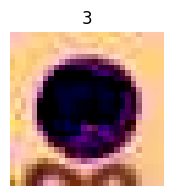

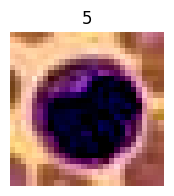

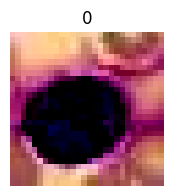

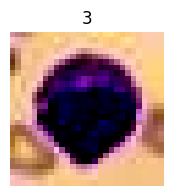

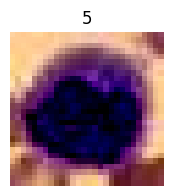

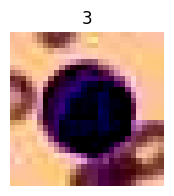

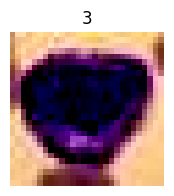

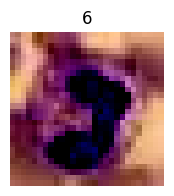

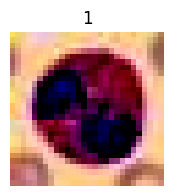

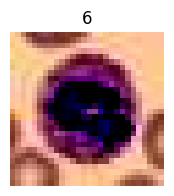

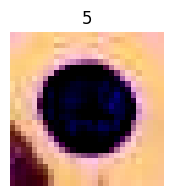

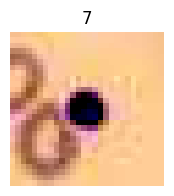

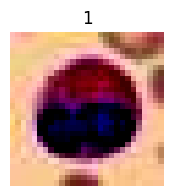

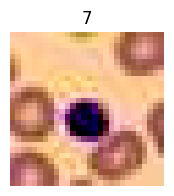

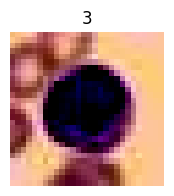

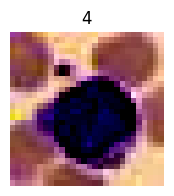

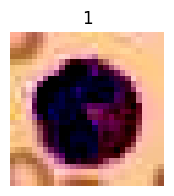

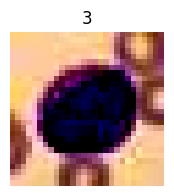

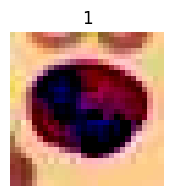

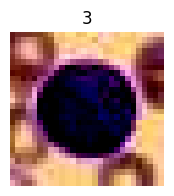

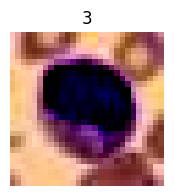

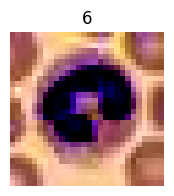

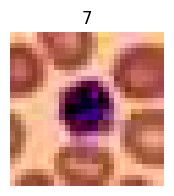

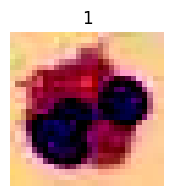

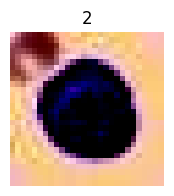

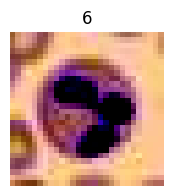

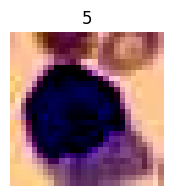

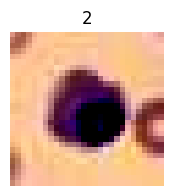

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC B

In [69]:
# Your code

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tensorflow as tf
from medmnist import INFO, Evaluator

info = INFO['bloodmnist']
data_labels = info['label']

# Función que permite visualizar los aspectos fundamentales sobre cada
# dataset que se haya descargado/cargado previamente.
def dataset_visualizer(dataset,length_montage):

  for i in range(0,length_montage*length_montage):
    img = dataset[i][0]
    label = str(dataset[i][1]).replace('[','')
    figure = plt.figure(figsize=(2,2))
    plt.imshow(img.permute(1,2,0))
    plt.title(data_labels[label.replace(']','')])
    plt.axis("off")
  plt.show()

# Visualizador de las imágenes a través de un pipeline DataLoader
def dataloader_visualizer(dataset,num_batches):
  data_loader = data.DataLoader(dataset,batch_size=28,shuffle=True)
  for batch_idx, (features, labels) in enumerate(data_loader):
      if batch_idx >= num_batches:
        break
      for i in range(len(features)):
        img = features[i].squeeze()
        label = str(labels[i]).replace('tensor([','').replace('])','')
        plt.figure(figsize=(2,2))
        plt.title(label)
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        plt.show()


dataloader_visualizer(blood_train_dataset,1)
print(blood_train_dataset)
print(blood_valid_dataset)
print(blood_test_dataset)


#Generate a dataloader

A convinient option for accessing data in torch is with the use of the Dataloader class. These work directly when given a MNIST dataset as input.
You can also apply any necesary preprocesing steps directly as you load the data with the Transforms package and the transform MNIST argument.

Choose apropiate values for the training hiperparameters (you can experiment with sampling strategies if you want) and implement the adecuate preprocesing steps. Finally, choose an Mnist dataset and create the dataloader for the training, validation and test splits.

In [84]:
# Parameters
NUM_EPOCHS = 20
BATCH_SIZE = 28
lr = 0.0001
DOWNLOAD_OK = True
data_flag = 'bloodmnist'
im_size = 3

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
num_classes = len(info['label'])

# Tupla que contiene los valores asociados a los parámetros mostrados anteriormente,
# con el fin de mejorar la organización de dichos parámetros.
parameters = {"num_epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE, "lr": lr, "download_ok": DOWNLOAD_OK,
              "data_flag": data_flag, "im_size": im_size,"info_task": task, "n_channels": n_channels,
              "num_classes": num_classes}

# Función que permite encapsular la carga de los datasets
def dataset_loading(train_dataset,valid_dataset,test_dataset,parameters):
  train_loader = data.DataLoader(dataset=train_dataset, batch_size=parameters["batch_size"], shuffle=True)
  valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=parameters["batch_size"], shuffle=False)
  test_loader = data.DataLoader(dataset=test_dataset, batch_size=parameters["batch_size"], shuffle=True)

  return train_loader, valid_loader, test_loader

# Función que representa la métrica de error asociada al modelo predictivo
def loss_function(task):
  return torch.nn.CrossEntropyLoss()

# Función que representa el optimizador utilizado para el modelo predictivo
def model_optimizer(model):
  #return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  return torch.optim.Adam(model.parameters(),lr=lr)

train_loader,valid_loader,test_loader = dataset_loading(blood_train_dataset,
                                                        blood_valid_dataset,
                                                        blood_test_dataset,
                                                        parameters)

print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))


3
428
62
123


#Create a deep learning model

In [75]:
# Define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes, im_size):
        super(Net, self).__init__()
        #Define the desired deep learning model
        #Your code

        #Primera capa del modelo de red convolucional
        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels,10,kernel_size=3),
            #nn.Conv2d(in_channels, 16, kernel_size=3),
            #nn.BatchNorm2d(16),
            #nn.ReLU())
        )

        #Segunda capa del modelo de red convolucional
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=3),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2))
        )

        #Tercera capa del modelo de red convolucional
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 30, kernel_size=3),
            #nn.BatchNorm2d(64),
            #nn.ReLU())
        )

        #Cuarta capa del modelo de red convolucional
        self.layer4 = nn.Sequential(
            nn.Conv2d(30, 40, kernel_size=3),
            #nn.BatchNorm2d(64),
            #nn.ReLU())
        )

        #Quinta capa del modelo de red convolucional
        self.layer5 = nn.Sequential(
            nn.Conv2d(40, 50, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2))
        )

        # Capa FC (full-conected)
        self.fc = nn.Sequential(
            nn.Linear(50,n_channels)
            #nn.Linear(64 * 4 * 4, 128),
            #nn.ReLU(),
            #nn.Linear(128, 128),
            #nn.ReLU(),
            #nn.Linear(128, num_classes))
        )

        #End your code

    def forward(self, x):
        #Your code

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        #x = x.view(x.size(0), -1)
        x = self.fc(x)

        #End your code

class SimpleNet(nn.Module):
  def __init__(self,in_channels,num_classes,im_size):
    super(Net, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(n_channels,10,kernel_size=3)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(10,20,kernel_size=3)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(20,30,kernel_size=3)
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(30,40,kernel_size=3)
    )

    self.layer5 = nn.Sequential(
        nn.Conv2d(40,50,kernel_size=3)
    )

    self.fc = nn.Sequential(
        nn.Linear(50,n_channels)
    )


  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = self.fc(x)

def net_model_visualizer(net_model):
  print(net_model)
  print('Total Parameters:',
       sum([torch.numel(p) for p in net_model.parameters()])
  )
  print('Trainable Parameters:',
       sum([torch.numel(p) for p in net_model.parameters() if p.requires_grad])
  )

#model = Net(in_channels=n_channels, num_classes=num_classes, im_size = im_size)

#Train Model

Implement the main traning loop to train the deep learning model.
This should include the forward and backward passes. You can find information about how to do this with torch in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id14

In [86]:
# Train the model
def train_epoch(model, train_loader, optimizer, criterion, task):
    model.train()

    correct = 0
    total_loss = 0
    total_samples = 0

    for batch_idx, (X, y) in enumerate(train_loader):
        pred = model(X)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(pred, 1)
        total_samples += y.size(0)
        correct += (predicted == y).sum().item()
        total_loss += loss.item() * y.size(0)

    return {
        "train_acc": correct / total_samples,
        "train_loss": total_loss / total_samples,
    }

def centralized_training(train_loader,test_loader,parameters):
  centralized_model = Net(in_channels=parameters["n_channels"],
                            num_classes=parameters["num_classes"],
                            im_size=parameters["im_size"])

  net_model_visualizer(centralized_model)
  optimizer = torch.optim.Adam(centralized_model.parameters(),lr=lr)
  criterion = torch.nn.L1Loss()

  for epoch in range(parameters["num_epochs"]):
    train_history = train_epoch(centralized_model,train_loader,optimizer,criterion,task)
    #valid_history = validate_epoch(centralized_model,test_loader,criterion,task)
    #print(f'Epoch {epoch}: {train_history} - {valid_history}')



centralized_training(train_loader,test_loader,parameters)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  )
  (layer3): Sequential(
    (0): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  )
  (layer4): Sequential(
    (0): Conv2d(30, 40, kernel_size=(3, 3), stride=(1, 1))
  )
  (layer5): Sequential(
    (0): Conv2d(40, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=3, bias=True)
  )
)
Total Parameters: 36573
Trainable Parameters: 36573


RuntimeError: mat1 and mat2 shapes cannot be multiplied (28000x20 and 50x3)

#Evaluation

Finally, implement the evaluation of the object clasification task. You can implement any metric you want, though the most common are accuracy and AUC (one class against all for the multiclass task). You can use torch.no_grad() for speeding up predictions when no gradients are needed.

How do you compare with the MedMNIST benchmarks?

In [ ]:
# Evaluation

# Your code
def model_evaluation_dataset(split):
  model.eval()

  y_true = torch.tensor([])
  y_score = torch.tensor([])

  data_loader = train_loader_at_eval if split == 'train' else test_loader

  with torch.no_grad():
    for inputs, targets in data_loader:
      outputs = model(inputs)

      if task == 'multi-label, binary-class':
        targets = targets.to(torch.float32)
        outputs = outputs.softmax(dim=-1)
      else:
        targets = targets.squeeze().long()
        outputs = outputs.softmax(dim=-1)
        targets = targets.float().resize_(len(targets), 1)

      y_true = torch.cat((y_true, targets), 0)
      y_score = torch.cat((y_score, outputs), 0)

    y_true = y_true.numpy()
    y_score = y_score.detach().numpy()

    evaluator = Evaluator(data_flag, split)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

print('==> Evaluating ...')
model_evaluation_dataset('test')

==> Evaluating ...


NameError: name 'test' is not defined